In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans

Load the points from both datasets.

In [2]:
circle = pd.read_csv('Circle.csv', header=None, names=['x', 'y'])
spiral = pd.read_csv('Spiral.csv', header=None, names=['x', 'y', 'label'])
circle.head(), spiral.head()

(        x        y
 0  2.7147  0.81472
 1  2.8054  0.94572
 2  2.0253  0.20682
 3  2.8096  1.03310
 4  2.5257  0.79188,
        x     y  label
 0  31.95  7.95      3
 1  31.15  7.30      3
 2  30.45  6.65      3
 3  29.70  6.00      3
 4  28.90  5.55      3)

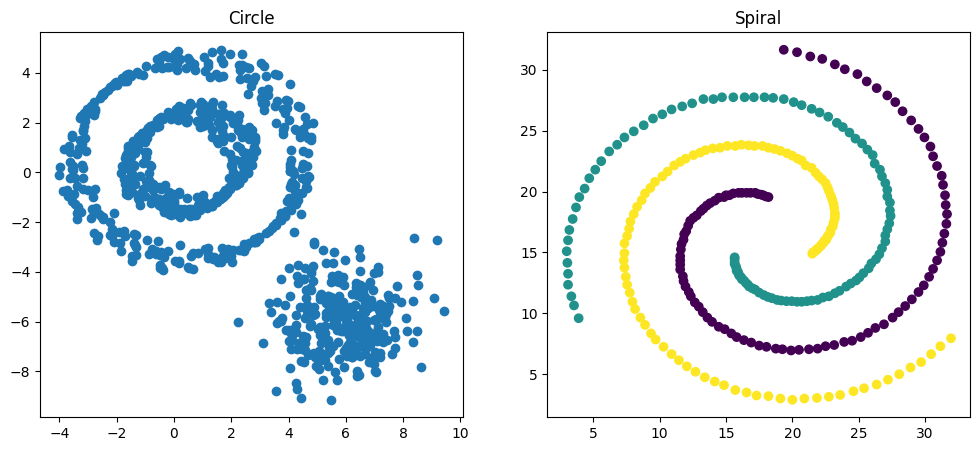

In [3]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(circle['x'],circle['y'])
ax[0].set_title('Circle')
ax[1].scatter(spiral['x'],spiral['y'],c=spiral['label'])
ax[1].set_title('Spiral')
plt.show()

In [4]:
circle_points = circle[['x', 'y']].values
spiral_points = spiral[['x', 'y']].values

Define the similarity function.

In [5]:
def create_similarity_matrix(X, sigma): 
    n_points = X.shape[0]
    similarity_matrix = np.zeros((n_points, n_points))

    for i in range(n_points):
        for j in range(n_points):
            similarity_matrix[i, j] = np.exp(-(np.linalg.norm(X[i] - X[j]))**2 / (2 * sigma**2))

    return similarity_matrix


Given a set of data points X and the similarity function, construct the k-nearest neighborhood similarity graph and its adjacency
matrix W. 

In [6]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors

def create_adjacency_matrix(X, k, sigma=1):        
    similarity_matrix = create_similarity_matrix(X, sigma)
    np.fill_diagonal(similarity_matrix, 0)  # diagonal elements are zero by definition
    # keep only the k highest values for each row/columns in the similarity matrix
    n_points = similarity_matrix.shape[0]
    W = np.zeros_like(similarity_matrix)

    for i in range(n_points):
        row = similarity_matrix[i]
        top_k_indices = np.argsort(row)[-k:]
        W[i, top_k_indices] = row[top_k_indices]

    W = np.maximum(W,W.T) # so that W is symmetric
    return W
 

In [7]:
W = create_adjacency_matrix(circle_points, 10)

Construct the degree matrix D and the Laplacian matrix L = D −W . 

In [8]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])    

In [9]:
W = csr_matrix(W)
D = csr_matrix(D)

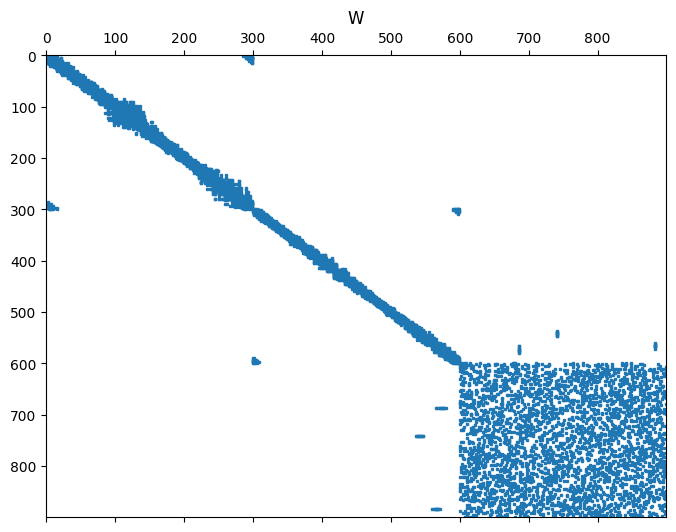

In [10]:
plt.figure(figsize=(8, 6))
plt.spy(W, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

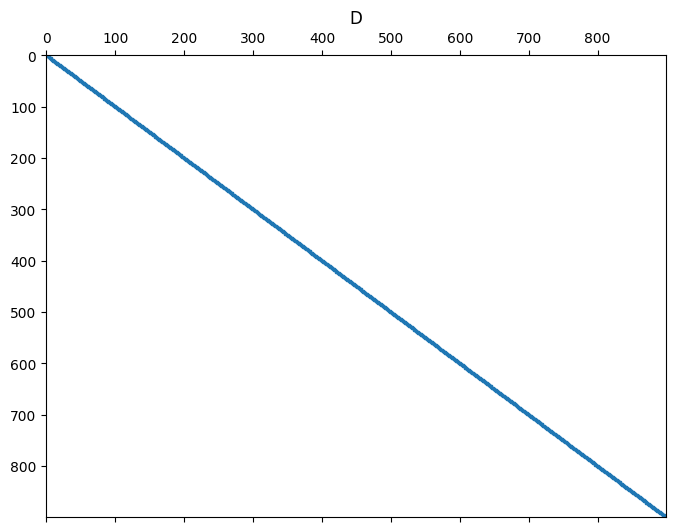

In [11]:
plt.figure(figsize=(8, 6))
plt.spy(D, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("D")
plt.show()

In [12]:
L = D - W

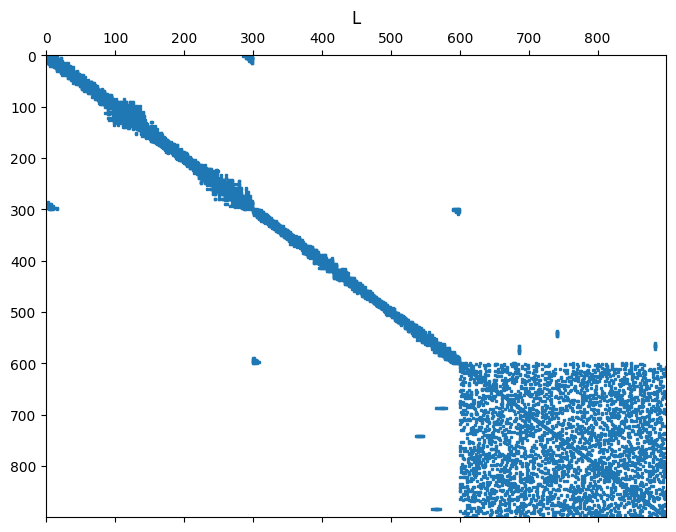

In [13]:
plt.figure(figsize=(8, 6))
plt.spy(L, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("L")
plt.show()

Compute the number of connected components of the similarity graph. ????

In [30]:
eigenvalues, eigenvectors = eigsh(L, k=15, which='SM')

In [25]:
eigenvalues

array([-1.48212967e-15, -1.21774202e-15,  4.82160471e-03,  2.85855994e-02,
        4.24743739e-02,  4.28866418e-02,  8.05548369e-02,  1.26366833e-01,
        1.34924780e-01,  2.09032833e-01,  2.17250376e-01,  2.20814780e-01,
        2.52650176e-01,  2.81419352e-01,  2.93845733e-01])

Compute some small eigenvalues of L and use their values to choose a
suitable number of clusters M for the points data-sets.

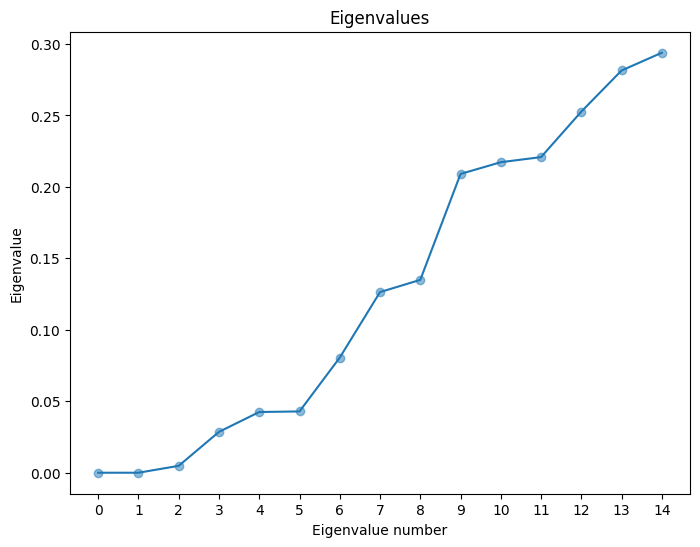

In [28]:
#plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
plt.scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
plt.xticks(np.arange(0,15,step=1))
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues")
plt.show()

Compute the $M$ eigenvectors $u_1, u_2, \dots, u_M \in \mathbb{R}^N$ that correspond to the $M$ smallest eigenvalues of the Laplacian matrix. Define the matrix $U \in \mathbb{R}^{N \times M}$ with these eigenvectors as columns. We try with M=2 and M=3.
For $i = 1, \dots, N$, let $\mathbf{y}_i \in \mathbb{R}^M$ be the vector corresponding to the $i$-th row of $U$. Cluster the points $\mathbf{y}_i$, $i = 1, \dots, N$ in $\mathbb{R}^M$ with the $k$-means algorithm into clusters $C_1, \dots, C_M$.

In [37]:
def show_clustering(df):
    plt.figure(figsize=(8, 6))  
    plt.scatter(df['x'], df['y'], c=df['cluster'])
    plt.title("K-means clustering")
    plt.show()

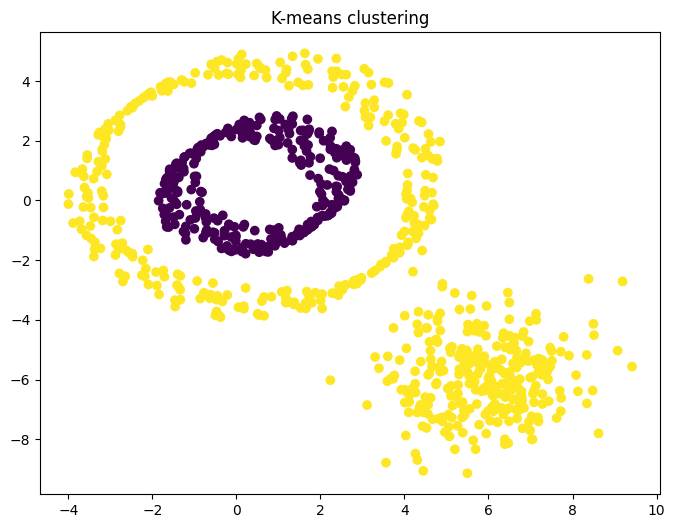

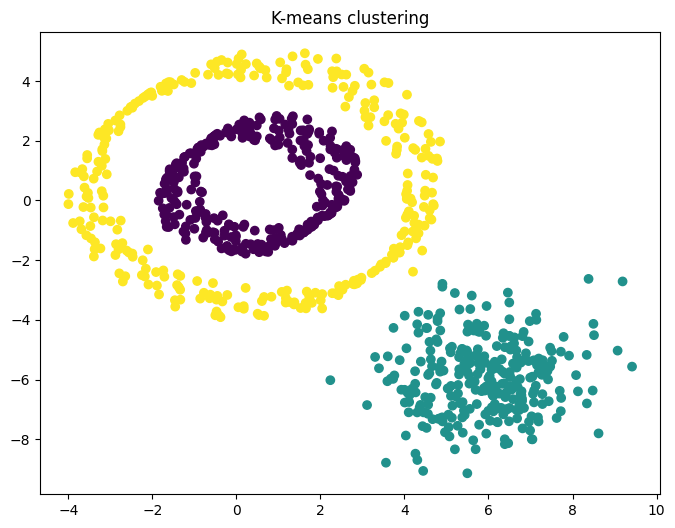

In [39]:
M = [2,3]
for m in M:
    U = eigenvectors[:, 0:m] 
    km = KMeans(n_clusters=m)
    km.fit(U)
    circle['cluster'] = km.labels_ 
    show_clustering(circle)

In [41]:
W = create_adjacency_matrix(spiral_points, 10)

In [42]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])    

In [43]:
W = csr_matrix(W)
D = csr_matrix(D)

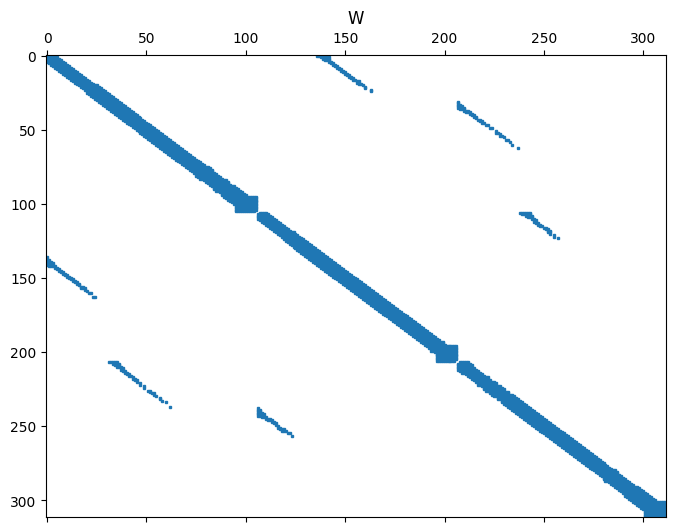

In [44]:
plt.figure(figsize=(8, 6))
plt.spy(W, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

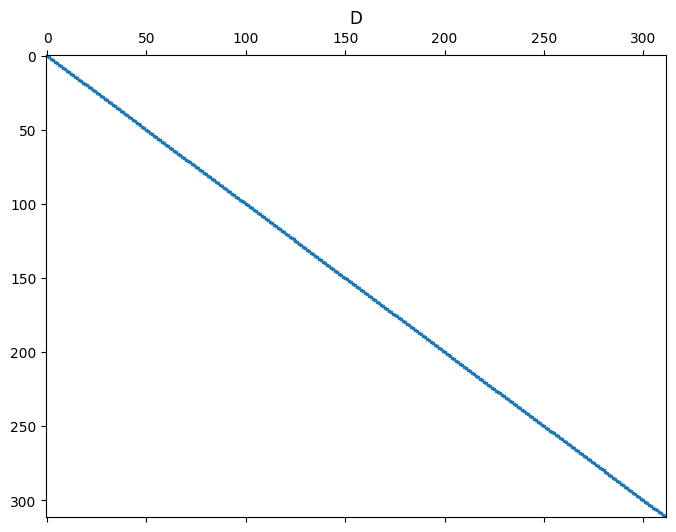

In [45]:
plt.figure(figsize=(8, 6))
plt.spy(D, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("D")
plt.show()

In [46]:
L = D - W

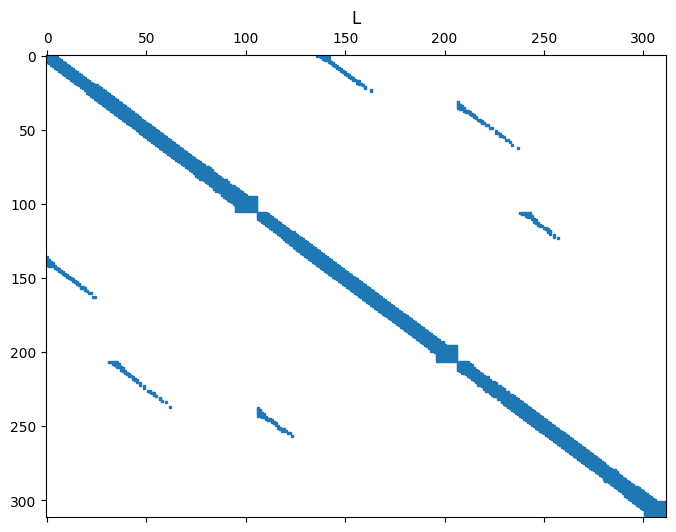

In [47]:
plt.figure(figsize=(8, 6))
plt.spy(L, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("L")
plt.show()

In [48]:
eigenvalues, eigenvectors = eigsh(L, k=15, which='SM')

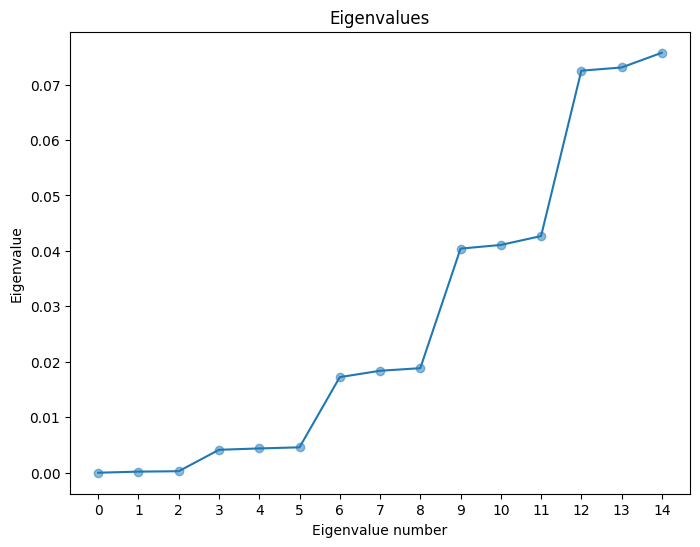

In [49]:
#plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
plt.scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
plt.xticks(np.arange(0,15,step=1))
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues")
plt.show()

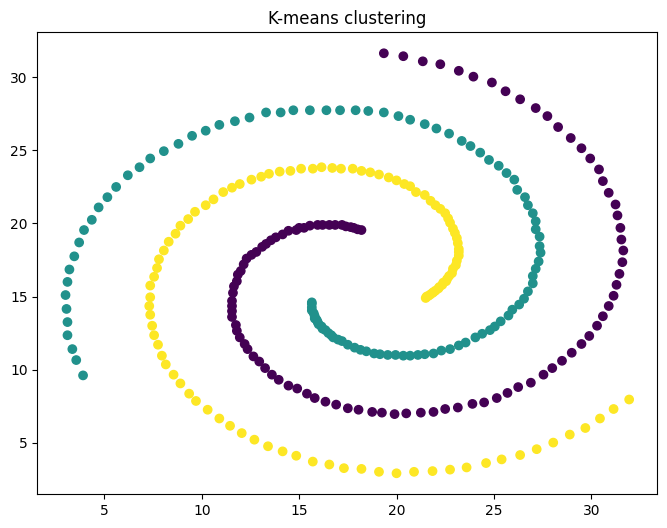

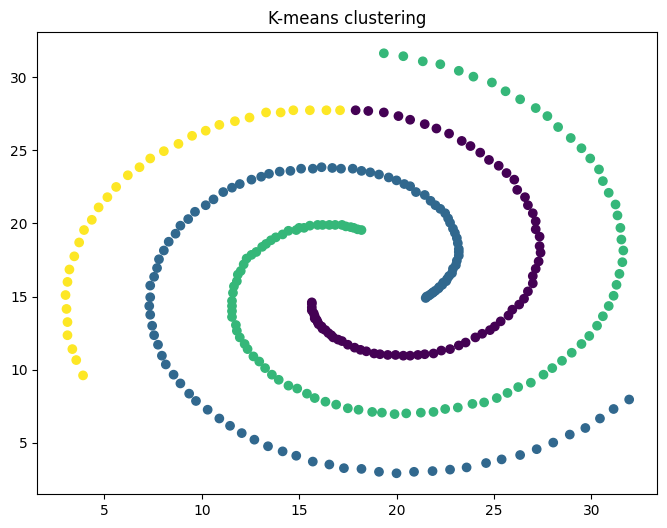

In [52]:
M = [3,4]
for m in M:
    U = eigenvectors[:, 0:m] 
    km = KMeans(n_clusters=m)
    km.fit(U)
    spiral['cluster'] = km.labels_ 
    show_clustering(spiral)

Compute the clusters for the same set of points with other clustering
methods (k-means,...) and compare the results.